<IPython.core.display.Javascript object>


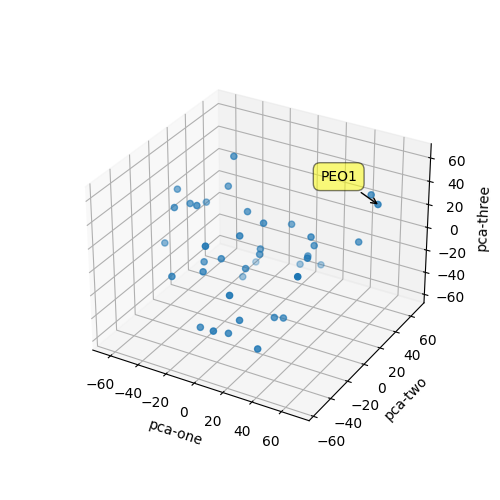

Sample-Gene Matrix size:  (40, 16248)
Explained variation per principal component: [0.07263939 0.06937508 0.06464197]
Closest neighbours: 
           similarity_score sample_name
A2780             16.734991      OVK-18
Caov-4            22.375620      OAW-28
DOV13             16.315115         KGN
EFO-21            27.036380      OAW-42
EFO-27            19.143853       SW626
ES-2              25.811215         Hey
FU-OV-1           13.729988       OV-90
Hey               20.452188         KGN
IGROV-1           22.573722      OAW-42
JHOS-2            31.225673     OVCAR-5
JHOS-3            31.121550      JHOS-4
JHOS-4            18.305597      OAW-28
KGN               11.239234        OV-7
KURAMOCHI         14.364136      OAW-28
OAW-28            14.364136   KURAMOCHI
OAW-42            17.656491       OVMIU
OC-314            10.745620       OV-90
OV-17R            19.234736   KURAMOCHI
OV-56             27.816250         RKN
OV-7              11.239234         KGN
OV-90             10.

,cluster-labels
A2780,0
Caov-4,7
DOV13,6
EFO-21,-1
EFO-27,-1
ES-2,6
FU-OV-1,3
Hey,6
IGROV-1,2
JHOS-2,-1


In [15]:
# PCA and clustering parameters:
MIN_SAMPLES_IN_CLUSTER = 2
# Determines the minimum steepness on the reachability plot that constitutes a cluster boundary.
# between 0 and 1
XI = 0.05

MIN_CLUSTER_SIZE = None

from numpy import split
from numpy.random import sample
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import scipy
from sklearn.cluster import OPTICS

%matplotlib notebook

file = 'CosmicExpressionsOvary.csv'
df = pd.read_csv(file, sep=',')
genes = df['GENE_NAME'].unique().tolist()
sample_gene_matrix = df.pivot_table(index='SAMPLE_NAME', values='Z_SCORE', columns='GENE_NAME', aggfunc='mean')
# Generating CSV file
sample_gene_matrix.to_csv('SampleGeneMatrix.csv')

# Dimensionality reduction using PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(sample_gene_matrix.values)

pca_matrix = pd.DataFrame()
pca_matrix['sample-name'] = sample_gene_matrix.index
pca_matrix['pca-one'] = pca_result[:,0]
pca_matrix['pca-two'] = pca_result[:,1] 
pca_matrix['pca-three'] = pca_result[:,2]

# Plot result
import seaborn as sns
import mplcursors

fig = plt.figure(figsize=(5,5))
ax = fig.gca(projection='3d')
ax.scatter(
    xs=pca_matrix["pca-one"], 
    ys=pca_matrix["pca-two"], 
    zs=pca_matrix["pca-three"], 
    cmap='tab10',
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')

# Displaying label on mouse hover
mplcursors.cursor().connect(
    "add", lambda sel: sel.annotation.set_text(pca_matrix['sample-name'][sel.target.index]))
plt.show();

print ('Sample-Gene Matrix size: ', sample_gene_matrix.shape)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
#print (pca_matrix)

def calculatePCAsimilartiyMatrix(pca_matrix):
    ary = scipy.spatial.distance.cdist(pca_matrix[["pca-one", "pca-two", "pca-three"]], 
                                        pca_matrix[["pca-one", "pca-two", "pca-three"]], 
                                        metric='euclidean')
    similarity_matrix = pd.DataFrame(ary, index= pca_matrix['sample-name'], columns=pca_matrix['sample-name'])
    # Generating CSV file
    similarity_matrix.to_csv('cell_line_similarity_matrix.csv')
    #print ("\nSimilarity matrix: ")
    #print (similarity_matrix)
    return similarity_matrix


def findClosestNeighbours(similarity_matrix):
    similarity_matrix = similarity_matrix.replace({ 0:np.nan})
    #print (similarity_matrix.min(),  similarity_matrix.idxmin())
    neighbours = pd.DataFrame( data ={ 'similarity_score':similarity_matrix.min(),
                                        'sample_name': similarity_matrix.idxmin()},
                                index= similarity_matrix.index.values)
    

    # look for lowest values in matrix and print their indexes (sample names)
    print ("Closest neighbours: ")
    print (neighbours)
    return neighbours

def clustering(pca_matrix):
    data = pca_matrix[["pca-one", "pca-two", "pca-three"]]
    clust = OPTICS(min_samples=MIN_SAMPLES_IN_CLUSTER, xi=XI, min_cluster_size=MIN_CLUSTER_SIZE)
    clust.fit(data)
    clusters = pd.DataFrame(data = {'cluster-labels': clust.labels_}, index = similarity_matrix.index.values)
    print ("\n Clusters(Noisy samples and points which are not included in a leaf cluster of cluster_hierarchy_ are labeled as -1.): ")
    print (clusters.sort_values('cluster-labels'))
    return clusters


similarity_matrix = calculatePCAsimilartiyMatrix(pca_matrix)
findClosestNeighbours(similarity_matrix)
clustering(pca_matrix)